In [1]:
import math
import random

import numpy as np
from numba import njit
import matplotlib.pyplot as plt

In [2]:
def gen_ring_sample(c: tuple, r1: float, r2: float, n: int):
        data = []
    
        for i in range(n):
            angle = random.uniform(0, 2*math.pi)
            dist = random.uniform(r1, r2)

            data.append([c[0]+dist*math.cos(angle), c[1]+dist*math.sin(angle)])
        
        return np.array(data)

def gen_circle_smaple(c: tuple, r: float, n: int):
    data = []
    
    for i in range(n):
        angle = random.uniform(0, 2*math.pi)
        dist = random.uniform(0, r)

        data.append([c[0]+dist*math.cos(angle), c[1]+dist*math.sin(angle)])
    
    return np.array(data)

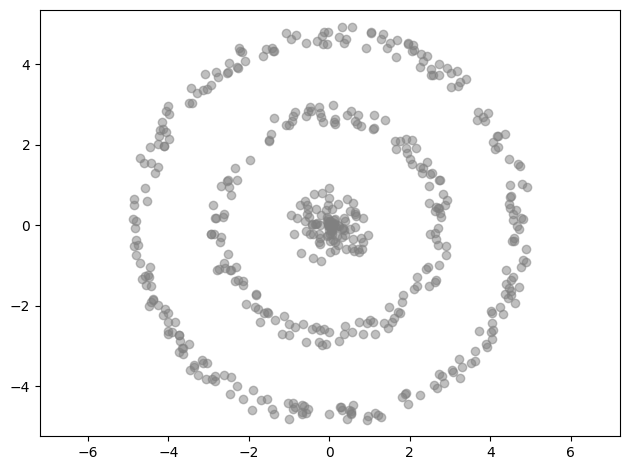

In [3]:
n_sample1 = 100
n_sample2 = 150
n_sample3 = 250

sample1 = gen_circle_smaple((0,0), 1, n_sample1)
sample2 = gen_ring_sample((0,0), 2.5, 3, n_sample2)
sample3 = gen_ring_sample((0,0), 4.5, 5, n_sample3)

data = np.vstack((sample1, sample2, sample3))

plt.scatter(data[:,0], data[:,1], c='gray', alpha=0.5)

plt.axis('equal')
plt.tight_layout()
plt.show()

In [4]:
@njit(fastmath=True)
def ReLU(x: np.ndarray) -> np.ndarray:
    return np.maximum(np.zeros(x.shape), x)


@njit(fastmath=True)
def dReLU(x: np.ndarray) -> np.ndarray:
    return 1 * (x > 0)


@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


@njit(fastmath=True)
def dSigmoid(x: np.ndarray) -> np.ndarray:
    y = 1 / (1 + np.exp(-x))
    return y * (1 - y)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> float:
    y = np.exp(x)
    return y / np.sum(y)

In [11]:
@njit(fastmath=True)
def calc_forces(x: np.ndarray, p: np.ndarray) -> None:
    nn = p.shape[0]
    nx = x.shape[0]
    
    forces: np.ndarray = np.zeros(p.shape)
    
    for i in range(nn):
        dir_x = x - p[i]
        dx = np.sum(np.square(dir_x), axis=1).reshape((nx, 1))
        attr_forces = 1 / (dx + 1) * dir_x
        
        dir_pi = p[i] - p
        dp = np.sum(np.square(dir_pi), axis=1).reshape((nn, 1))
        separation_forces = 1 / (dp + 1) * dir_pi
        
        mean_attr_force = 1 / nx * np.sum(attr_forces, axis=0)
        mean_sep_force = 1 / nn * np.sum(separation_forces, axis=0)

        forces[i] = mean_attr_force + mean_sep_force
        
    return forces


@njit(fastmath=True)
def activate(x: np.ndarray, p: np.ndarray, d: np.ndarray) -> np.ndarray:
    s = np.zeros(p.shape[0])

    dx = np.square(p - x)
    q = 1 / (np.sum(dx, axis=1) + 1)

    for j in range(p.shape[0]):
        s[j] += np.sum(q / (d[j] + 1))
    
    return s

In [12]:
class SelfOrganizingMap:
    def __init__(self, n: int) -> None:
        self.n: int = n

        self.p: np.ndarray = None
        self.d: np.ndarray = None

    def _init_weights(self, data: np.ndarray):
        self.p = np.random.uniform(-1, 1, (self.n, data.shape[1]))
    
    def recalc_dist_mtrx(self):
        self.d = np.zeros((self.n, self.n))

        for i, pi in enumerate(self.p):
            for j, pj in enumerate(self.p):
                self.d[i][j] = np.sum(np.square(pi - pj))
    
    def activate(self, x: np.ndarray) -> np.ndarray:
        return activate(x, self.p, self.d)

    def train(self, x_train: np.ndarray, lr: float, batch_size: int, max_epoch: int) -> None:
        n = x_train.shape[0]
        n_batches = n // batch_size

        self._init_weights(x_train)

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)

            for i in range(n_batches):
                ibegin = i * batch_size
                iend = min((i + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]

                forces = calc_forces(x_train[batch_idxs], self.p)

                self.p += lr * forces

In [41]:
m = 5
n = m * m

learning_rate = 1.0
batch_size = 16
max_epoch = 64

model = SelfOrganizingMap(n)
model.train(data, learning_rate, batch_size, max_epoch)

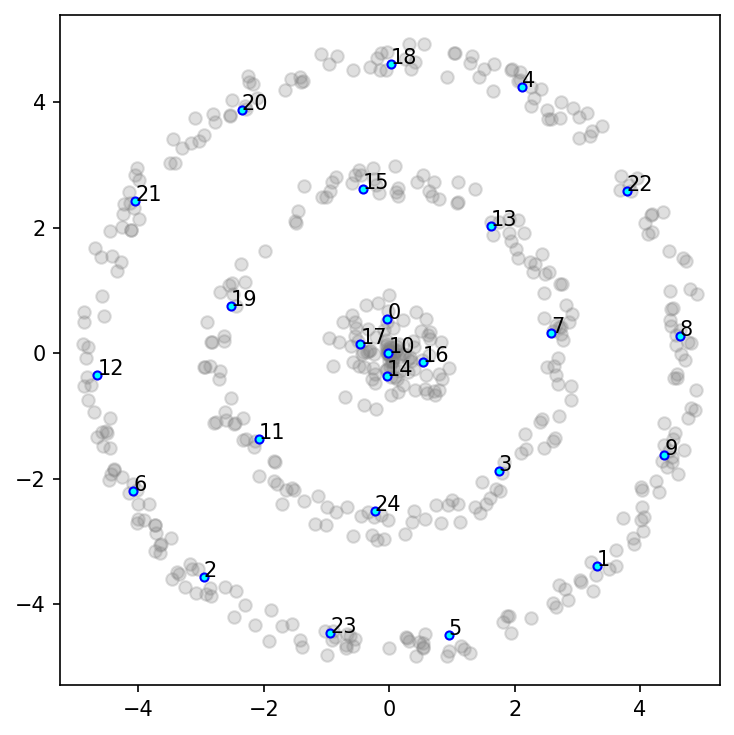

In [42]:
fig = plt.figure(figsize=(5, 5), dpi=150)
ax = fig.add_subplot()

ax.scatter(data[:,0], data[:,1], c='gray', alpha=0.25)
ax.scatter(model.p[:, 0], model.p[:, 1], s=15, c='cyan', edgecolors='blue')

for i in range(n):
    ax.annotate(str(i), (model.p[i][0], model.p[i][1]))

plt.axis('equal')
plt.tight_layout()
plt.show()

In [16]:
scores = np.zeros((n, 3))

for i in range(n_sample1):
    d = 1 / np.sum(np.square(sample1[i] - model.p), axis=1) / n_sample1
    idx = np.argmax(d)
    scores[idx][0] += 1

for i in range(n_sample2):
    d = 1 / np.sum(np.square(sample2[i] - model.p), axis=1) / n_sample2
    idx = np.argmax(d)
    scores[idx][1] += 1

for i in range(n_sample3):
    d = 1 / np.sum(np.square(sample3[i] - model.p), axis=1) / n_sample3
    idx = np.argmax(d)
    scores[idx][2] += 1

In [17]:
print(scores)

[[ 0. 21.  0.]
 [ 0.  0. 18.]
 [ 0.  0. 22.]
 [ 0. 22.  0.]
 [ 0.  0. 18.]
 [ 0. 22.  0.]
 [ 0.  0. 20.]
 [ 0.  0. 20.]
 [ 0.  0. 24.]
 [39.  0.  0.]
 [ 0.  0. 18.]
 [13.  0.  0.]
 [ 0.  0. 21.]
 [ 0.  0. 17.]
 [ 0.  0. 15.]
 [ 0. 18.  0.]
 [ 0. 25.  0.]
 [18.  0.  0.]
 [ 0.  0. 19.]
 [ 0.  0. 20.]
 [14.  0.  0.]
 [ 0.  0. 18.]
 [ 0. 19.  0.]
 [ 0. 23.  0.]
 [16.  0.  0.]]


In [18]:
from math import sqrt

In [19]:
@njit(fastmath=True)
def norm(x: np.ndarray) -> float:
    return sqrt(np.sum(np.square(x)))


@njit(fastmath=True)
def norm_squared(x: np.ndarray) -> float:
    return np.sum(np.square(x))


@njit(fastmath=True)
def cosim(a: np.ndarray, b: np.ndarray) -> float:
    return (a @ b) / (norm(a) * norm(b))


@njit(fastmath=True)
def mcosim(m: np.ndarray, x: np.ndarray) -> np.ndarray:
    y = np.zeros(m.shape[0])
    x_norm = norm(x)
    
    for i in range(m.shape[0]):
        y[i] = (m[i] @ x) / (norm(m[i]) * x_norm)
        
    return y

In [20]:
scores2 = np.apply_along_axis(softmax, 1, scores)

In [21]:
print(np.round(scores2.T, 3))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
  1.]
 [1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1.
  0.]
 [0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0.
  0.]]


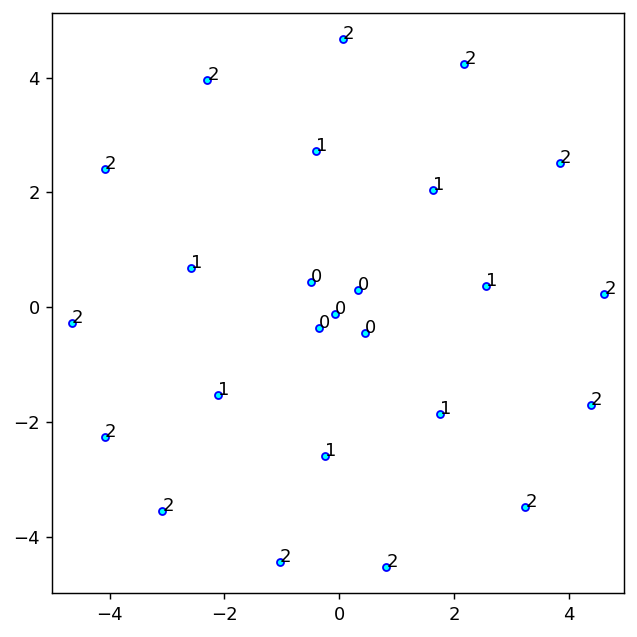

In [22]:
fig = plt.figure(figsize=(5,5), dpi=130)
ax = fig.add_subplot()

ax.scatter(model.p[:, 0], model.p[:, 1], s=15, c='cyan', edgecolors='blue')

for i in range(n):
    ax.annotate(str(np.argmax(scores2[i])), (model.p[i][0], model.p[i][1]))

plt.axis('equal')
plt.tight_layout()
plt.show()

In [23]:
class_belong = np.array([0.0, 0.0, 0.0])

for i in range(model.n):
    class_belong[np.argmax(scores2[i])] += 1

print(class_belong)

[ 5.  7. 13.]


In [25]:
predicted_classes = []

for x in data:
    q = 1 / np.apply_along_axis(norm_squared, 1, model.p - x)
    q = (scores2.T * q).T
    q = np.sum(q.T, 1)

    predicted_classes.append(np.argmax(q))

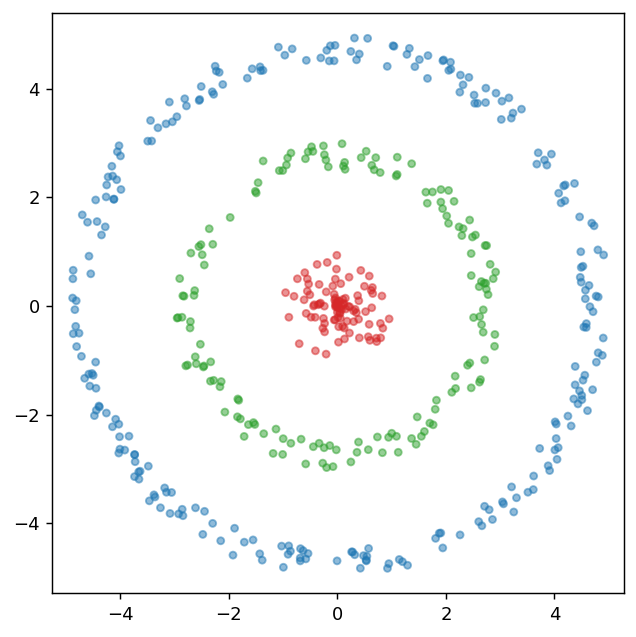

In [30]:
fig = plt.figure(figsize=(5,5), dpi=130)
ax = fig.add_subplot()

clr_map = {
    0 : 'tab:red',
    1 : 'tab:green',
    2 : 'tab:blue'
}

colors = list([clr_map[i] for i in predicted_classes])

ax.scatter(data[:, 0], data[:, 1], s=15, c=colors, alpha=0.5)

plt.axis('equal')
plt.tight_layout()
plt.show()